## Milestone 2

## **Model Building - Approach**
1. Data preparation
2. Partition the data into train and test set
3. Fit on the train data
4. Tune the model and prune the tree, if required
5. Test the model on test set

In [8]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,recall_score,f1_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

import scipy.stats as stats

from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load the new data set, without outliers and missing values
models_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/MIT/ADSP/Cap/models_df.csv')
#Inspect the new data set with no missing values 
models_df.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

# Data Preparation

In [3]:
#Convert depdent variable to category
models_df['BAD'] = models_df['BAD'].astype('category')

In [4]:
#Dummy variables for the categorical values
to_get_dummies_for = ['REASON', 'JOB']
models_df = pd.get_dummies(data = models_df, columns= to_get_dummies_for, drop_first= True) 

In [5]:
# Drop the dependent variable from the dataframe and create 
#the X(independent variable) matrix
X = models_df.drop(columns = ['BAD'])

In [6]:
#Create y(dependent variable)
y = models_df['BAD']

# Scaling the data

Since the independent variables have different scales it is customary to scale the data, in order to avoid that a higher weightage will be given to features that have a higher magnitude. In this case i will use the Standard Scaler method, which centers and scales the dataset using the Z-Score.

In [9]:
sc=StandardScaler()
X_scaled=sc.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled, columns=X.columns)

# Splitting the data into 70% train and 30% test set

In [10]:
x_train,x_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.3,random_state=1,stratify=y)

I chose a 70:30 partition among sets, and changed the paramater stratified to y, due to the fact that there can be
imbalances in the distribution of classes. The stratified sampling technique is used to ensure that relative 
class frequencies are approximately preserved in each train and validation fold.

# Model Evaluation Criterion

In [11]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Model evaluation criterion

#### The model can make two types of wrong predictions:

1. Predicting a client is elegible when the client is not elegible for a loan (The client is more likely to default)
2. Predicting a client is not eleigible for a loan and the client actually is. (The client is less likely to default)


#### Implications 

1. In this first case (Eligible/Not Eligible)the bank losses money
2. In the second case (Not Eligible/Eligible) the bank losses a client.

In the short termn, the first case is more important, but in the long term the second could limit the bank to 
expnad its base o clients.
In terms of defaulting the first case is relevant to the business, in that way, the bank would like to maximize the precision, the greater the recall, the bank is more likely to have less defaulters, hence, losse less money.
Precion gives us a metric of how much our model is precise in predicting 1 (The defulters/Not Eligible).

# Build a Logistic Regression Model

In [12]:
# Defining the Logistic regression model
lg=LogisticRegression()
# Fitting the model on the training data 
lg.fit(x_train,y_train)

LogisticRegression()

**Checking the performance on the train dataset**

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2749
           1       0.72      0.30      0.42       646

    accuracy                           0.84      3395
   macro avg       0.79      0.64      0.67      3395
weighted avg       0.83      0.84      0.82      3395



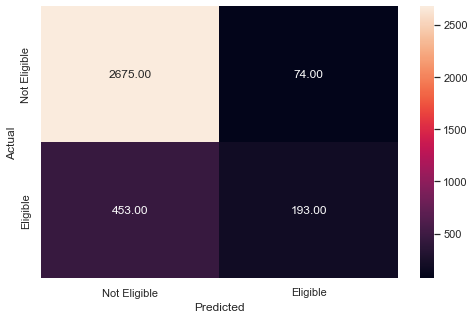

In [14]:
#Predict for train set
y_pred_train = lg.predict(x_train)
#checking the performance on the train dataset
metrics_score(y_train, y_pred_train)

**Checking the performance on the test dataset**

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1179
           1       0.68      0.29      0.41       277

    accuracy                           0.84      1456
   macro avg       0.77      0.63      0.66      1456
weighted avg       0.82      0.84      0.81      1456



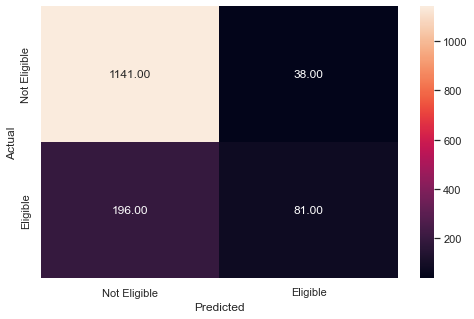

In [15]:
#Predict for test set
y_pred_test = lg.predict(x_test)
#checking the performance on the test dataset
metrics_score(y_test, y_pred_test)

**Observations**
We are getting an overall accuracy of the model, in the train and test set, of about 84%.
Precision is around 70%, in the train and test set. But recall is particularly low in both sets, around 30%.
This means that the model is not performing well in predicting those customers who might be eligible for a loan.


**Let's check the coefficients, and check which variables are important and how they affect the process of loan approval**

In [16]:
cols=X.columns
coef_lg=lg.coef_
pd.DataFrame(coef_lg,columns=cols).T.sort_values(by=0,ascending=False)

,0
DELINQ,0.801281
DEROG,0.469254
DEBTINC,0.397229
NINQ,0.282845
REASON_2,0.174324
JOB_5,0.162763
JOB_6,0.108250
JOB_4,0.036942
YOJ,0.029098
VALUE,0.011031


**Observations**

The features, that are affecting the rate of eligibility are: number of major derogatory reports, number of delinquet lines, debt to income ratio and number of recent credit inquiries.

**Tunning the model**

Scince our model does not performs very well we can try to improve it tunning the thresholds.
Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.

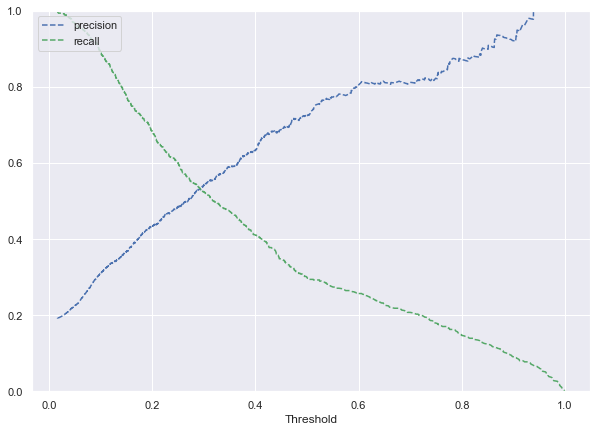

In [17]:
y_scores_lg=lg.predict_proba(x_train) 
precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_train, y_scores_lg[:,1])


plt.figure(figsize=(10,7))
plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label='precision')
plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

Observation:

We can see that precision and recall are balanced for a threshold of about ~0.30.

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2749
           1       0.54      0.52      0.53       646

    accuracy                           0.82      3395
   macro avg       0.71      0.71      0.71      3395
weighted avg       0.82      0.82      0.82      3395



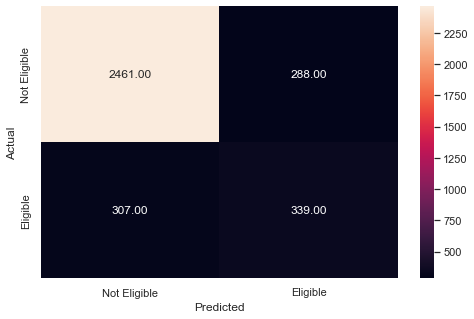

In [18]:
#Check the model at this new threshold
optimal_threshold1=.30
y_pred_train = lg.predict_proba(x_train)
metrics_score(y_train, y_pred_train[:,1]>optimal_threshold1)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1179
           1       0.52      0.51      0.51       277

    accuracy                           0.82      1456
   macro avg       0.70      0.70      0.70      1456
weighted avg       0.82      0.82      0.82      1456



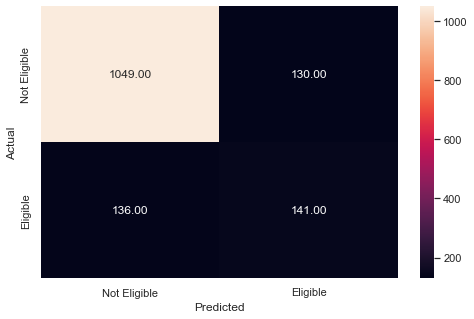

In [20]:
#Check the performance on the test data
optimal_threshold1=.30
y_pred_test = lg.predict_proba(x_test)
metrics_score(y_test, y_pred_test[:,1]>optimal_threshold1)

**Observations**
The overall accuracy of the model was reduced, in the train and test set, from 84% to 82%, with this changes. Precision was also reduced from 70% to 52%, in the train and test set. But recall increased in both sets, to  50%. So the trade off was an increase of recall but a decrease in precision, which in terms of a business recommendation for the bank is not sufficient. Since we would like to improve the overall accuracy of the model, and both precision and recall.

# Decision Tree 

In [22]:
#I have already treated the data, and created a data frame for this models
models_tree = pd.read_csv('/Volumes/GoogleDrive/My Drive/MIT/ADSP/Cap/models_df.csv')
models_tree['BAD'] = models_tree['BAD'].astype('category')

**Separating the target variable y and independent variable x**

In [24]:
# Drop the dependent variable from the dataframe and create 
#the X(independent variable) matrix
X = models_tree.drop(columns = ['BAD'])


#Create y(dependent variable)
Y = models_tree['BAD']

**Split the data**

In [25]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=1,stratify=Y)

**Building a decision tree model**

In [26]:
#Defining Decision tree model with class weights class_weight={0: 0.2, 1: 0.8}
dt = DecisionTreeClassifier(class_weight={0:0.20,1:0.80}, random_state=1)

#fitting decision tree
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2749
           1       1.00      1.00      1.00       646

    accuracy                           1.00      3395
   macro avg       1.00      1.00      1.00      3395
weighted avg       1.00      1.00      1.00      3395



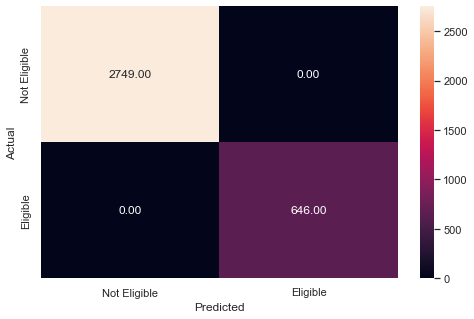

In [27]:
#checking performance on train dataset
y_train_pred_dt=dt.predict(x_train)
metrics_score(y_train,y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1179
           1       0.64      0.58      0.61       277

    accuracy                           0.86      1456
   macro avg       0.77      0.75      0.76      1456
weighted avg       0.85      0.86      0.86      1456



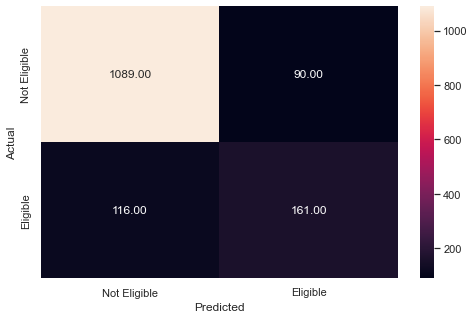

In [28]:
#checking performance on test dataset
y_test_pred_dt=dt.predict(x_test)
metrics_score(y_test,y_test_pred_dt)

**Observations:**

The decision tree works perfect on the training set (100%), but no so well on the test set, as the precision is 64%, recall is 58% and overall accuracy is 86%.
The fact that the decision tree model works perfectly in the the trainning set might mean that the model is over-fitting the data.
The precision on the test means that there is a 36% (1-.64) chance, that the model will predict a client is eligible for a loan, even though he/she is not. What implies a loss of money for the bank.


**Decision Tree - Hyperparameter Tuning**

In [29]:
# Choose the type of classifier 
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.20,1:0.80}, random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,7), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25]
             }


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label=1)

# Run the grid search
gridCV= GridSearchCV(dtree_estimator, parameters, scoring=scorer,cv=10)
gridCV = gridCV.fit(x_train, y_train)

# Set the classifier to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

# Fit the best estimator to the data 
dtree_estimator.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=6,
                       min_samples_leaf=25, random_state=1)

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2749
           1       0.65      0.80      0.72       646

    accuracy                           0.88      3395
   macro avg       0.80      0.85      0.82      3395
weighted avg       0.89      0.88      0.88      3395



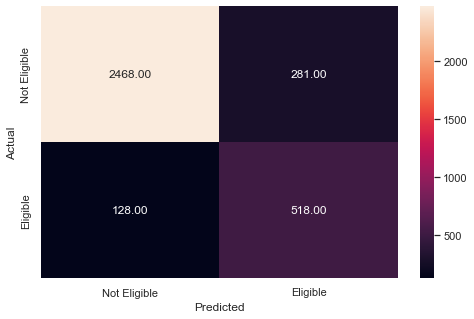

In [30]:
# Checking performance on the training data based on the tuned model
y_train_pred_dt=dtree_estimator.predict(x_train)
metrics_score(y_train,y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1179
           1       0.60      0.71      0.65       277

    accuracy                           0.85      1456
   macro avg       0.76      0.80      0.78      1456
weighted avg       0.86      0.85      0.86      1456



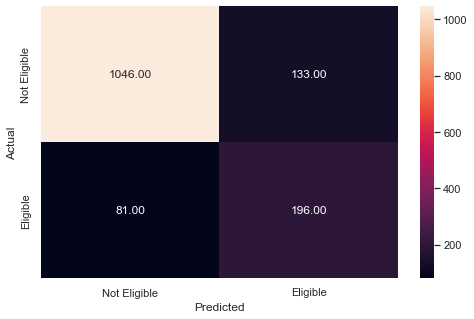

In [31]:
# Checking performance on the testing data based on the tuned model
y_test_pred_dt=dtree_estimator.predict(x_test)
metrics_score(y_test,y_test_pred_dt)

**Observations**

The tuned model is performing better than the first model, this new model is not overfitting the data.
Precision has gone down significantly slightly from .65 to .60 as compared to the previous model. which means the tuned model is not very good at identifying false positives (Predict Eligible, while not eligible).

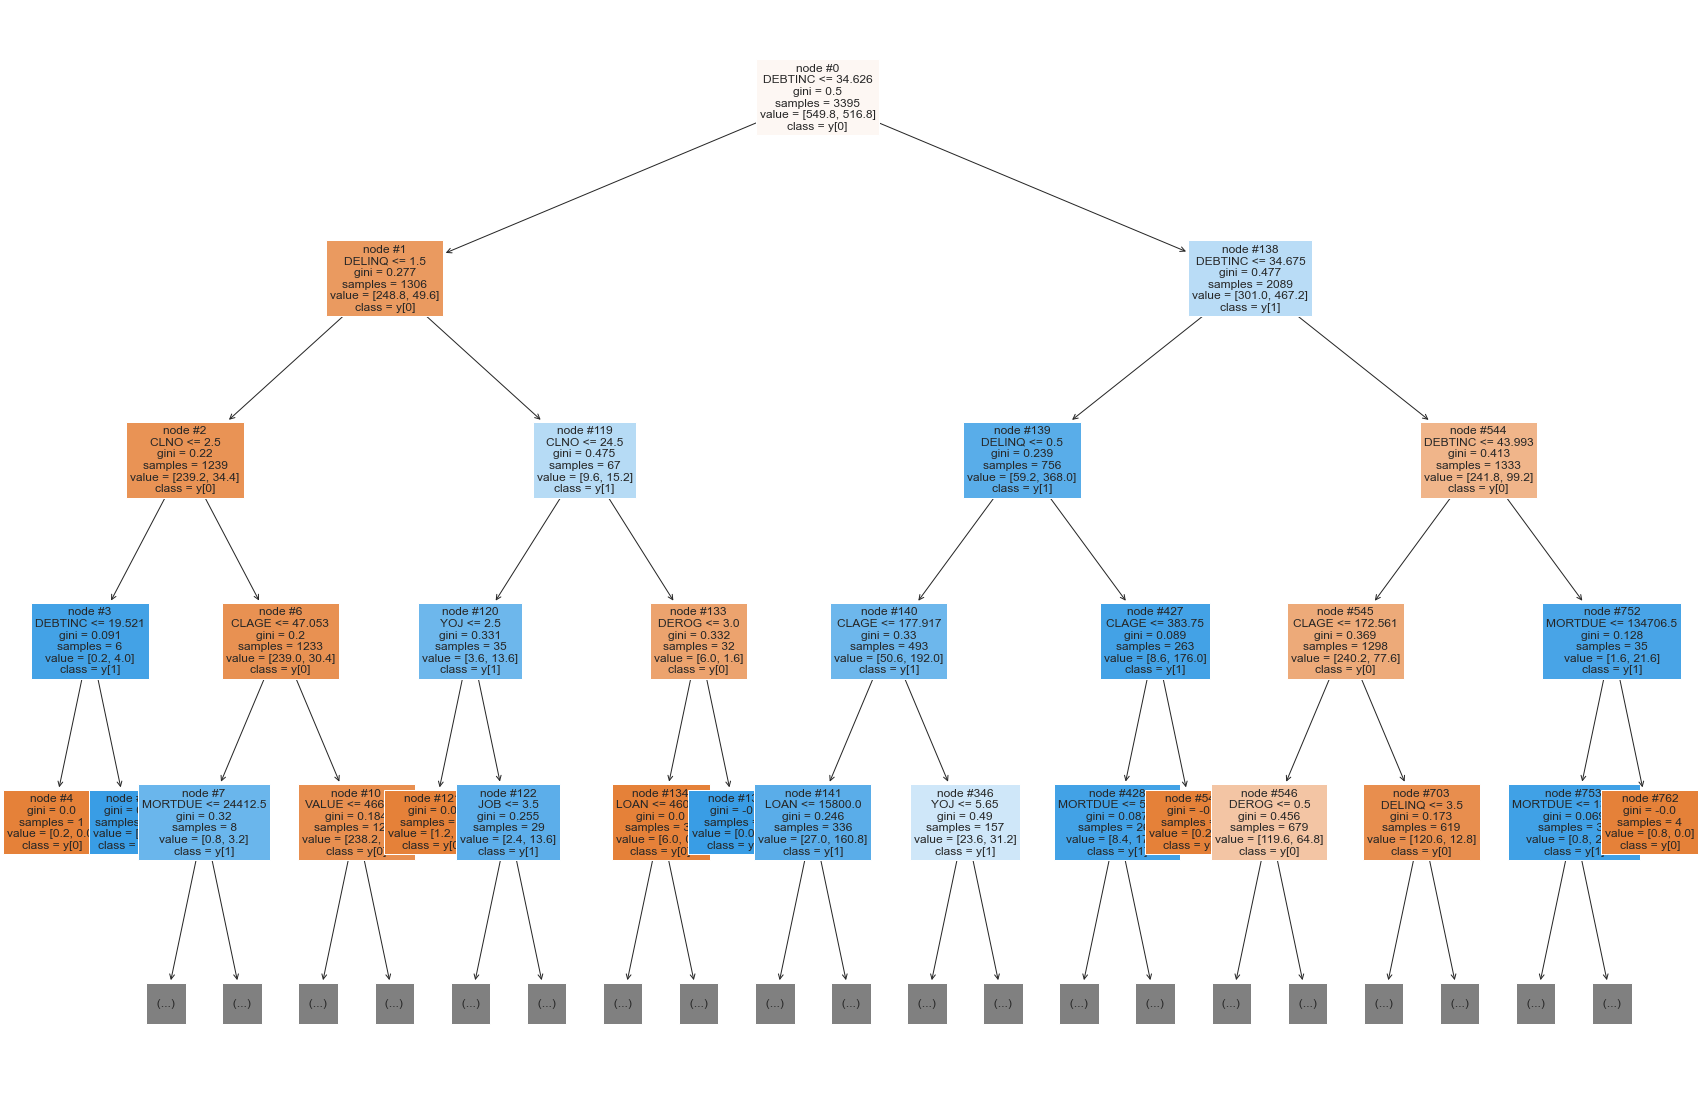

In [32]:
# Plot the decision  tree and analyze it to build the decision rule
features = list(X.columns)

plt.figure(figsize=(30,20))

tree.plot_tree(dt,max_depth=4,feature_names=features,filled=True,fontsize=12,node_ids=True,class_names=True)
plt.show()

**Observations:**

Clients that have a debt income ratio over 34.67, a number of delinquent lines over 0.5 and an age of the oldest credit line between 177 and 383 months, according to this model, are more likely to default.

The variables mentioned are in blue squares, and according to their gini coefficients the ones that contribute more to 
defaulting (1).

# Building a Random Forest Classifier


In [33]:
#Fitting the decision tree classifier on the training data 
rf_estimator = RandomForestClassifier(class_weight={0:0.20,1:0.80}, random_state=1)

rf_estimator.fit(x_train,y_train)

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2749
           1       1.00      1.00      1.00       646

    accuracy                           1.00      3395
   macro avg       1.00      1.00      1.00      3395
weighted avg       1.00      1.00      1.00      3395



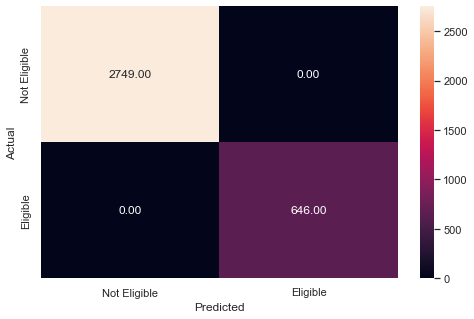

In [34]:
#Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(x_train)
metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1179
           1       0.81      0.62      0.70       277

    accuracy                           0.90      1456
   macro avg       0.86      0.79      0.82      1456
weighted avg       0.89      0.90      0.89      1456



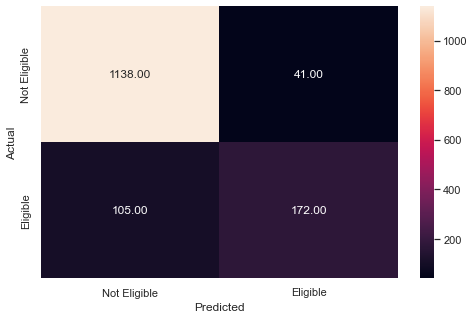

In [35]:
#Checking performance on the testing data
y_pred_test_rf = rf_estimator.predict(x_test)
metrics_score(y_test, y_pred_test_rf)

**Observations**

The results of the model in the training set are prone to ovefitting, and in the test set, the model has the best performance so far, compared with the Decision Tree and the Logistic models. (In both training and test set.)

**Changing the class weights**

Due to the fact that we are interested in predicting the defaulters (code = 1) giving more weight to them 
changing the hyperparameter and inverting it, has slight effect in the model. Specially in the test set. 
As shown below:

In [39]:
#Fitting the decision tree classifier on the training data 
rf_estimator = RandomForestClassifier(class_weight={0:0.80,1:0.20}, random_state=1)
rf_estimator.fit(x_train,y_train)

RandomForestClassifier(class_weight={0: 0.8, 1: 0.2}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2749
           1       1.00      1.00      1.00       646

    accuracy                           1.00      3395
   macro avg       1.00      1.00      1.00      3395
weighted avg       1.00      1.00      1.00      3395



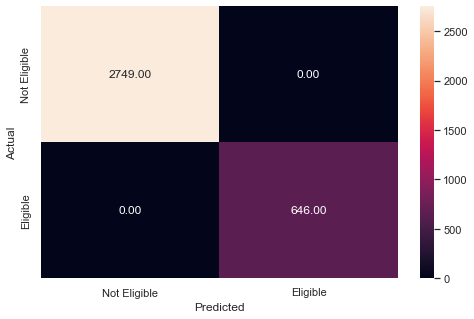

In [40]:
#Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(x_train)
metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1179
           1       0.84      0.68      0.75       277

    accuracy                           0.91      1456
   macro avg       0.89      0.82      0.85      1456
weighted avg       0.91      0.91      0.91      1456



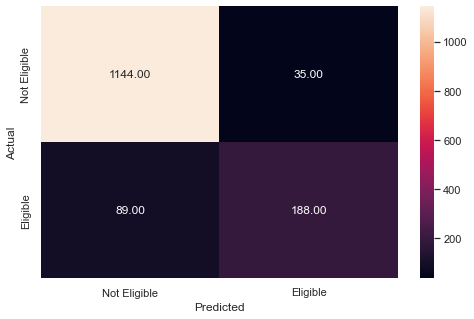

In [41]:
#Checking performance on the testing data
y_pred_test_rf = rf_estimator.predict(x_test)
metrics_score(y_test, y_pred_test_rf)

**Tuning the Random Forest**

In [42]:
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier(class_weight={0:0.80,1:0.20}, random_state=1)

# Grid of parameters to choose from
## add from article
params_rf = {  
        "n_estimators": [500],
        "min_samples_leaf": np.arange(5),
        "max_features": ['auto'],
}


# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = metrics.make_scorer(recall_score, pos_label=1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2749
           1       1.00      1.00      1.00       646

    accuracy                           1.00      3395
   macro avg       1.00      1.00      1.00      3395
weighted avg       1.00      1.00      1.00      3395



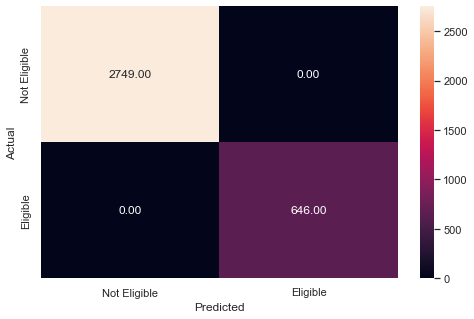

In [43]:
#Checking performance on the training data
y_pred_train_rf_tuned = rf_estimator_tuned.predict(x_train)
metrics_score(y_train, y_pred_train_rf_tuned)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1179
           1       0.85      0.66      0.75       277

    accuracy                           0.91      1456
   macro avg       0.89      0.82      0.85      1456
weighted avg       0.91      0.91      0.91      1456



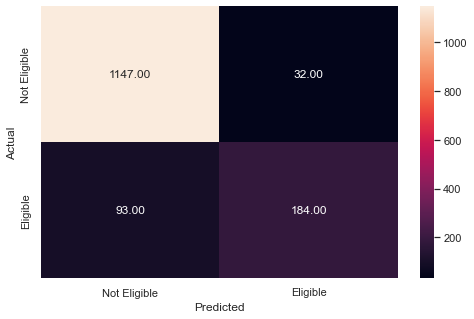

In [44]:
#Checking performance on the test data
y_pred_test_rf_tuned = rf_estimator_tuned.predict(x_test)
metrics_score(y_test, y_pred_test_rf_tuned)

**Observations**

After tunning the model, the perfomance of the it compared to the last did not improve significantly in overall accuracy. It decreases a little in recall, from 68% to 66%, and increased a little in precision from 84% to 86%. We can see that the changes with this tunning are marginal.

**Feature Importances**

<AxesSubplot:xlabel='Importance'>

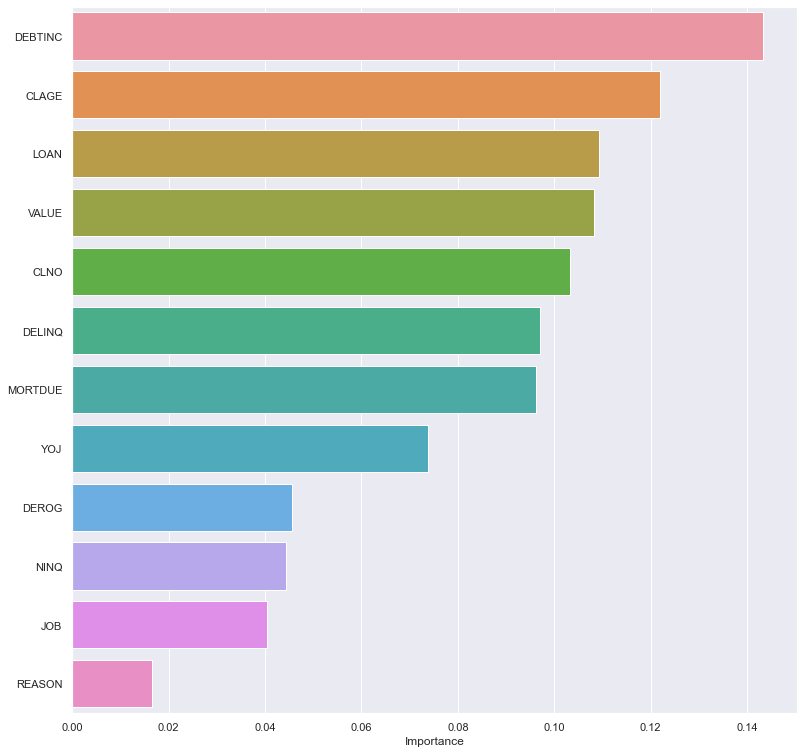

In [46]:
importances = rf_estimator.feature_importances_
columns=X.columns
importance_df=pd.DataFrame(importances,index=columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
plt.figure(figsize=(13,13))
sns.barplot(importance_df.Importance,importance_df.index)

**Observations**

The two most important variables that could predict class 1 are Debt to income rate, and Age of the oldest credit line in months, very similar to the Decsion Tree tuned model. 

**Feature Engineering Random Forest**

**Data Preparation**

In [75]:
#Im am going to drop all the variables (features) tha have less than .10% of importance in the last model.
#With this  changes one might think the accuracy and the precision of the model is going to increase.

#Make a copy of the data frames for trees, to avoid mistakes.
models_tree_feature = models_tree.copy()

#Drop all the variables that have a low importance < .10
X_f = models_tree_feature.drop(columns = ['BAD','YOJ', 'DEROG', 
                     'NINQ','JOB','REASON'])


#Create y(dependent variable)
Y_f = models_tree['BAD']

In [76]:
# Split the data into training and test set
x_train,x_test,y_train,y_test=train_test_split(X_f,Y_f,test_size=0.3,random_state=1,stratify=Y_f)

In [77]:
#Use the parameters in the last tuned model
rf_estimator_feature = RandomForestClassifier(class_weight={0:0.80,1:0.20}, 
                                              n_estimators = 500,
                                              min_samples_leaf= 5,
                                              max_features= 'auto', 
                                              random_state=1)

In [78]:
#fit the model
rf_estimator_feature.fit(x_train,y_train)


RandomForestClassifier(class_weight={0: 0.8, 1: 0.2}, min_samples_leaf=5,
                       n_estimators=500, random_state=1)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2749
           1       1.00      0.51      0.67       646

    accuracy                           0.91      3395
   macro avg       0.95      0.75      0.81      3395
weighted avg       0.92      0.91      0.89      3395



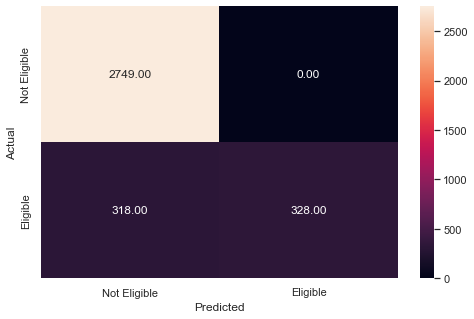

In [79]:
#Checking performance on the training data
y_pred_train_rf_estimator_feature = rf_estimator_feature.predict(x_train)
metrics_score(y_train, y_pred_train_rf_estimator_feature)

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1179
           1       0.90      0.44      0.59       277

    accuracy                           0.88      1456
   macro avg       0.89      0.71      0.76      1456
weighted avg       0.89      0.88      0.87      1456



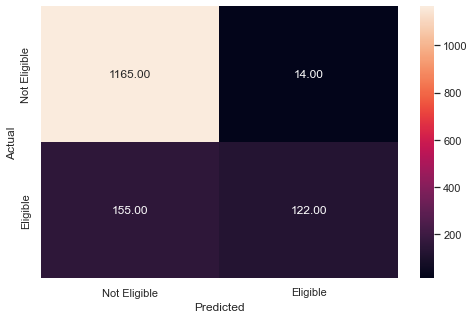

In [80]:
#Checking performance on the test data
y_pred_test_rf_estimator_feature = rf_estimator_feature.predict(x_test)
metrics_score(y_test, y_pred_test_rf_estimator_feature)

**Observations**

As we can see, the feature engineering did not improve the overall accuracy of the last model. It did improved the precsion on the test set, compared to the last model from 84% to 90%, but the recall is very low 43%. 
Therfore; it is not recommendable to have a model, that predicts very good one class, but fails to predict almost a little more than half of the other.

# **Other models**

**In this section I will present the results of three more models: LDA, QDA, and KNN Nearest Neighbors**

In [48]:
#Importing the necessary libraries

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [51]:
#splitting the data
x_train,x_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.3,random_state=1,stratify=y)

**LDA**

In [52]:
#fitting lda model
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)    

LinearDiscriminantAnalysis()

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      2749
           1       0.69      0.30      0.42       646

    accuracy                           0.84      3395
   macro avg       0.77      0.63      0.66      3395
weighted avg       0.82      0.84      0.81      3395



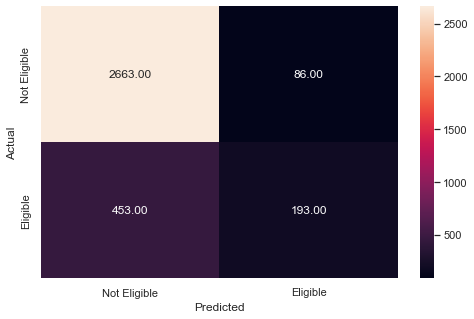

In [53]:
#checking model performance of lda
y_pred_train_lda = lda.predict(x_train)
metrics_score(y_train, y_pred_train_lda)   

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2749
           1       0.55      0.53      0.54       646

    accuracy                           0.83      3395
   macro avg       0.72      0.71      0.72      3395
weighted avg       0.83      0.83      0.83      3395



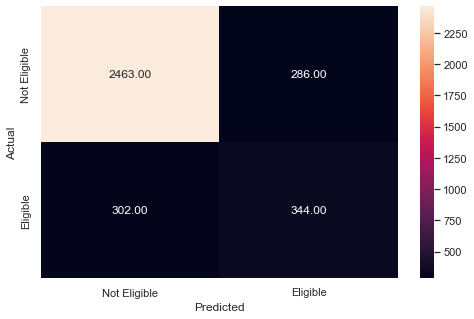

In [54]:
#Check model with new threshold on train set
optimal_threshold1=.25
y_pred_train_lda = lda.predict_proba(x_train)
metrics_score(y_train, y_pred_train_lda[:,1]>optimal_threshold1)  

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1179
           1       0.52      0.51      0.51       277

    accuracy                           0.82      1456
   macro avg       0.70      0.70      0.70      1456
weighted avg       0.82      0.82      0.82      1456



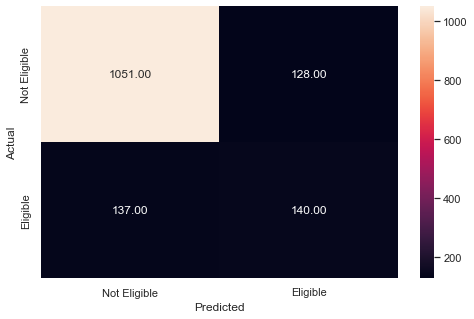

In [55]:
#Check model with new threshold on test set
optimal_threshold1=.25
y_pred_test_lda = lda.predict_proba(x_test)
metrics_score(y_test, y_pred_test_lda[:,1]>optimal_threshold1)  

**QDA**

In [56]:
 #fitting qda model
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)   

QuadraticDiscriminantAnalysis()

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2749
           1       0.56      0.40      0.47       646

    accuracy                           0.83      3395
   macro avg       0.71      0.66      0.68      3395
weighted avg       0.81      0.83      0.81      3395



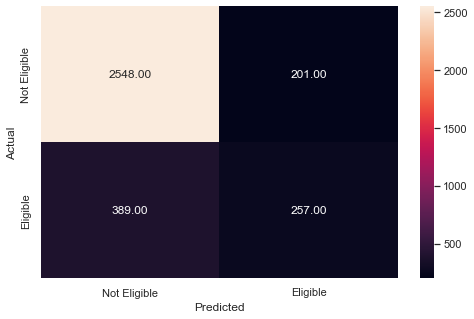

In [57]:
#checking model performance on the training data
y_pred_train_qda = qda.predict(x_train)
metrics_score(y_train, y_pred_train_qda)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1179
           1       0.52      0.36      0.42       277

    accuracy                           0.82      1456
   macro avg       0.69      0.64      0.66      1456
weighted avg       0.80      0.82      0.80      1456



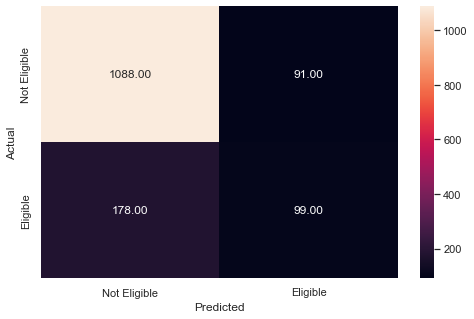

In [58]:
#checking performance of the model on the test data
y_pred_test_qda = qda.predict(x_test)
metrics_score(y_test, y_pred_test_qda)

**KNN Nearest Neighbors**

In [59]:
#define knn model
#The number of k-neighbors was defined previously via plotting k vs error
knn=KNeighborsClassifier(n_neighbors=5)

In [60]:
#fitting data to the KNN model
knn.fit(x_train,y_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2749
           1       0.99      0.59      0.74       646

    accuracy                           0.92      3395
   macro avg       0.95      0.79      0.85      3395
weighted avg       0.93      0.92      0.91      3395



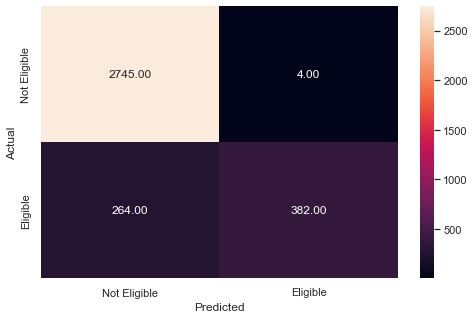

In [61]:
#checking the performance of knn model on the train set
y_pred_train_knn = knn.predict(x_train)
metrics_score(y_train, y_pred_train_knn)

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1179
           1       0.97      0.41      0.58       277

    accuracy                           0.89      1456
   macro avg       0.92      0.70      0.76      1456
weighted avg       0.89      0.89      0.87      1456



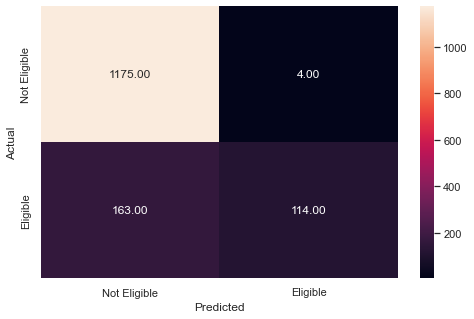

In [62]:
#checking the performance of knn model on the test set
y_pred_test_knn = knn.predict(x_test)
metrics_score(y_test, y_pred_test_knn)

# Comparing Model Performances

In [94]:
#I ran the code separately for the data frames with the same treatments, otherwise the code would not run. And created
# a separate table for each data frame with the code you provided.
#Models: Logistic (lg), Linear Discriminat Quadrant Analysis (lda), Quadrant Discriminant Analysis (qda), KNN Nearest
#Nieghbours (knn)
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,lg,0.844772,0.839286,0.298762,0.292419,0.722846,0.680672
1,lda,0.841237,0.841346,0.298762,0.303249,0.691756,0.688525
2,qda,0.826215,0.815247,0.397833,0.357401,0.561135,0.521053
3,knn,0.921060,0.885302,0.591331,0.411552,0.989637,0.966102


In [95]:
#Models: dt (Decision Tree), dtree_estimator (Decision Tree Tuned), rf_estimator_no (Random Forest), rf_estimator_1
#(Random Forest with weights inverted), rf_estimator_tuned (Random Forest with weights inverted and tunned)
comparison_frame2

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,dt,1.000000,0.860577,1.000000,0.577617,1.00000,0.650407
1,dtree_estimator,0.879529,0.853022,0.801858,0.707581,0.64831,0.595745
2,rf_estimator_no,1.000000,0.896291,1.000000,0.606498,1.00000,0.800000
3,rf_estimator_1,1.000000,0.914148,1.000000,0.653430,1.00000,0.861905
4,rf_estimator_tuned,1.000000,0.914148,1.000000,0.660650,1.00000,0.855140


In [97]:
#Models: rf_estimator_feature (Random Forest with feature engineering)
comparison_frame3 

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,rf_estimator_feature,0.905744,0.882555,0.504644,0.433213,1,0.895522


**Insights:**

Predicting the defaulters is more difficult as a class, since there are only 20% in the data set, which means, that several treatments of the data have to be made (inverting the weights of the dependent variable) in some cases.

According to our best model, the variables that are more likely to predict if a person is going to default (predict Eligible/actual Not Eligible), are Debt Income Ratio, and Age of the oldest credit line in months.

The technique that performed better was the random forest, followed by decision tress. There is an interesting trade off in the models made; some perform better in predicting one class (defaulters) and others are better in predicting the other class (not defaulters). This depends mainly in the weight of the class in the parameters of the models.

In this case through tunning we found a way to improve the performance of the models, but at a trade-off,  which was the less capability to predict the one class at the expense of predicting the other class better.


Assuming that the bank strategically in the long run would like; to both reduce defaulters and get new clients, the model the bank should adopt to pre-screen is the Random Forest (tunned, with the weights of the dependent variable inverted).

The reason for this is that, this model provides,  the best combination of overall accuracy, precision and recall, compared to other models.

If the bank only choses to reduce defaulters, the Random Forest model (tunned, and with weights inverted) would be the choice.
If the bank only choses to improve their clients base, the Decision Tress (tunned) would be the choice.
